# Types of learning and MCMC

##### Keywords: supervised learning, semi-supervised learning, unsupervised learning, mixture model, gaussian mixture model, pymc3, label-switching, identifiability, normal distribution, pymc3 potentials

We now do a study of learning mixture models with MCMC. We have already done this in the case of the Zero-Inflated Poisson Model, and will stick to Gaussian Mixture models for now.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm
import theano.tensor as tt

## Supervised and semi-supervised Learning

In other notes, we used mixture models to categorize the various types of learning. The key difference was how we wrote the likelihoods. Lets use those likelihoods to untertake sampling in supervised and semi-supervised ways. We have already seen unsupervised sampling

We'll use the heights-weights data set as we do have a story for why these outght to be separately gaussianly distributed for men and women.

In [2]:
df=pd.read_csv("data/01_heights_weights_genders.csv")
df.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [3]:
df.describe()

,Height,Weight
count,10000.000000,10000.000000
mean,66.367560,161.440357
std,3.847528,32.108439
min,54.263133,64.700127
25%,63.505620,135.818051
50%,66.318070,161.212928
75%,69.174262,187.169525
max,78.998742,269.989699


A KDEplot confirms our intuition

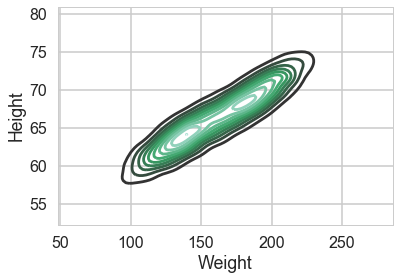

In [4]:
sns.kdeplot(df.Weight, df.Height)

To keep things simple, we'll keep to one dimension by sticking with the weight marginal. Plotting it, there definitely seems to be a double humped distribution:

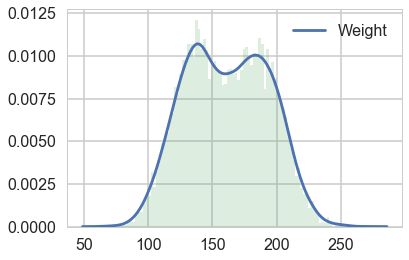

In [5]:
sns.kdeplot(df.Weight)
plt.hist(df.Weight, bins=100, alpha=0.2, normed=True);

In [47]:
df.shape

(10000, 3)

We do the train-test split. Notice we will keep a very small number of points in the training set.

In [48]:
makesmall=np.random.choice(range(df.shape[0]), size=500, replace=False)
datax=df.Weight.values
dataz=1*(df.Gender=='Male')
datax=datax[makesmall]
dataz=dataz.values[makesmall]
from sklearn.model_selection import train_test_split
itr, ite = train_test_split(range(dataz.shape[0]), train_size=0.04, stratify=dataz)
xte=datax[ite]
xtr=datax[itr]
zte=dataz[ite]
ztr=dataz[itr]


In [49]:
zte.shape, zte.mean(), ztr.mean(), ztr.shape

((480,), 0.48749999999999999, 0.5, (20,))

We use 2-D categoricals to make cluster assignments. Notice that these training assignments are also observed stochastics now, in addition to the $x$. 

In [50]:
with pm.Model() as classmodel1:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = tt.stack([p1, p2])
    #Notice the "observed" below
    assignment_tr = pm.Categorical("assignment_tr", p, 
                                observed=ztr)
    sds = pm.Uniform("sds", 0, 100, shape=2)
    centers = pm.Normal("centers", 
                        mu=np.array([130, 170]), 
                        sd=np.array([20, 20]), 
                        shape=2)
    p_min_potential = pm.Potential('lam_min_potential', tt.switch(tt.min(p) < .1, -np.inf, 0))
    order_centers_potential = pm.Potential('order_centers_potential',
                                         tt.switch(centers[1]-centers[0] < 0, -np.inf, 0))
    
    # and to combine it with the observations:
    observations = pm.Normal("obs", mu=centers[assignment_tr], sd=sds[assignment_tr], observed=xtr)
    

In [51]:
with classmodel1:
    step1 = pm.Metropolis(vars=[p, sds, centers])
    trace_cm1_full = pm.sample(10000, step=[step1], njobs=2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [centers]
>Metropolis: [sds_interval__]
>Metropolis: [p_interval__]
100%|██████████| 10500/10500 [00:05<00:00, 1864.73it/s]
The number of effective samples is smaller than 10% for some parameters.


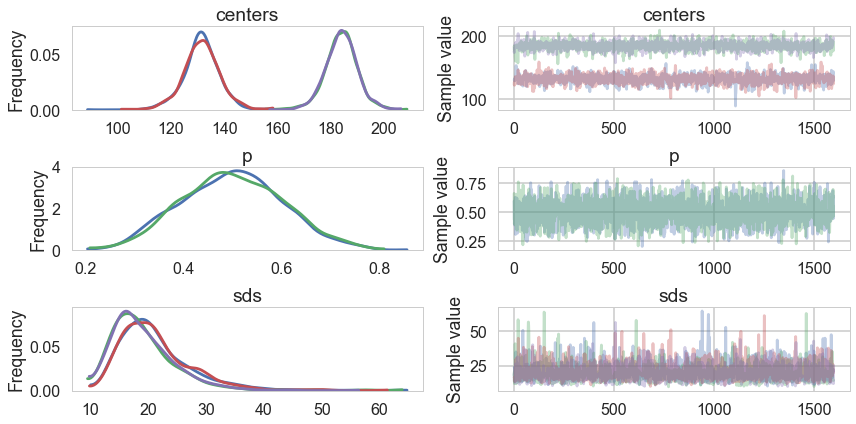

In [52]:
trace_cm1 = trace_cm1_full[2000::5]
pm.traceplot(trace_cm1);

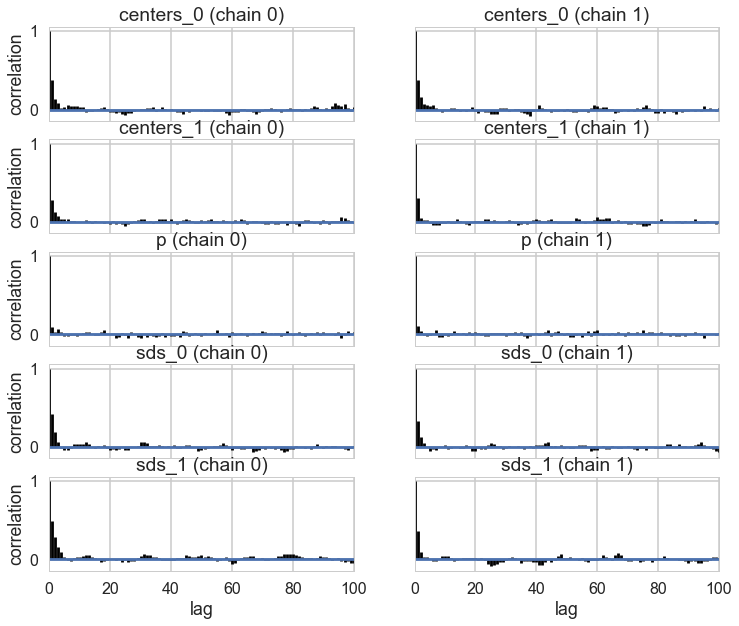

In [53]:
pm.autocorrplot(trace_cm1);

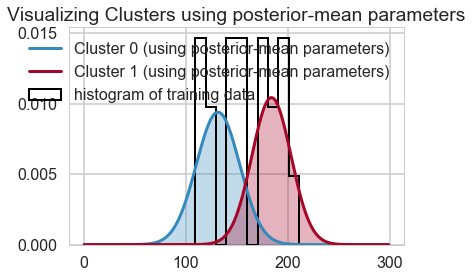

In [54]:
center_trace = trace_cm1["centers"]
std_trace = trace_cm1["sds"]
#identify the clusters
colors = ["#348ABD", "#A60628"] \
if center_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]
norm = sp.stats.norm
x = np.arange(0, 300, 1)
posterior_center_means = center_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = 1 - ztr.mean()


y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0],
                                scale=posterior_std_means[0])
plt.plot(x, y, label="Cluster 0 (using posterior-mean parameters)", color=colors[1], lw=3)
plt.fill_between(x, y, color=colors[1], alpha=0.3)

y = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
plt.plot(x, y, label="Cluster 1 (using posterior-mean parameters)", color=colors[0], lw=3)
plt.fill_between(x, y, color=colors[0], alpha=0.3)
plt.hist(xtr, bins=10, histtype="step", normed=True, color="k",
     lw=2, label="histogram of training data")
# plt.hist(xte, bins=20, histtype="step", normed=True, color="k",
#      lw=2, label="histogram of  test data")
plt.legend(loc="upper right")
plt.title("Visualizing Clusters using posterior-mean parameters")

We use the $p(x \vert z)$ to do our classification. What we really want is $p(z \vert x)$, but we can use bayes theorem to inver this, as shown in the diagram below.


![gen and dis](images/bishopgendis.png)



In [55]:
xgivenz0 = lambda x: norm.pdf(x, loc=posterior_center_means[0],
                                scale=posterior_std_means[0])
xgivenz1 = lambda x: norm.pdf(x, loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
zpred1 = 1*(xgivenz1(xte) > xgivenz0(xte))
from sklearn.metrics import confusion_matrix, accuracy_score
confusion_matrix(zte, zpred1)

array([[223,  23],
       [ 13, 221]])

In [56]:
accuracy_score(zte, zpred1)

0.92500000000000004

## Semi-Supervised Learning

In the previous section we did the work on the testing set separately. Here we'd like to model the fact that we have a partial likelihood available for the testing set: we have observed the $x$s, but not the $z$s.

Thus in our model we will include both training and testing $x$s, but only training $z$s as observations, fitting for the testing $z$s.
We now want the trace of the testing assignments. That is we want $p(z \vert x)$ and we'll use the MCMC model to do the whole bayes theorem inversion for us!

In [57]:
with pm.Model() as classmodel2:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = tt.stack([p1, p2])
    assignment_tr = pm.Categorical("assignment_tr", p, 
                                observed=ztr)
    # we do not know the test assignments
    assignment_te = pm.Categorical("assignment_te", p, 
                                shape=xte.shape[0])
    sds = pm.Uniform("sds", 0, 100, shape=2)
    centers = pm.Normal("centers", 
                        mu=np.array([130, 170]), 
                        sd=np.array([20, 20]), 
                        shape=2)
    p_min_potential = pm.Potential('lam_min_potential', tt.switch(tt.min(p) < .1, -np.inf, 0))
    order_centers_potential = pm.Potential('order_centers_potential',
                                         tt.switch(centers[1]-centers[0] < 0, -np.inf, 0))
    
    # and to combine it with the observations:
    observations_tr = pm.Normal("obs_tr", mu=centers[assignment_tr], sd=sds[assignment_tr], observed=xtr)
    observations_te = pm.Normal("obs_te", mu=centers[assignment_te], sd=sds[assignment_te], observed=xte)

In [58]:
with classmodel2:
    step1 = pm.Metropolis(vars=[p, sds, centers])
    step2 = pm.ElemwiseCategorical(vars=[assignment_te])
    trace_cm2_full = pm.sample(15000, step=[step1, step2])

//anaconda/envs/py3l/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  This is separate from the ipykernel package so we can avoid doing imports until
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds_interval__]
>>Metropolis: [p_interval__]
>ElemwiseCategorical: [assignment_te]
100%|██████████| 15500/15500 [03:07<00:00, 82.60it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [59]:
pm.summary(trace_cm2_full)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
assignment_te__0,0.002533,0.050268,0.000324,0.000000,0.000000,28072.0,0.999982
assignment_te__1,0.002700,0.051891,0.000370,0.000000,0.000000,30000.0,1.000017
assignment_te__2,0.348267,0.476421,0.005942,0.000000,1.000000,7151.0,1.000092
assignment_te__3,0.993433,0.080768,0.000493,1.000000,1.000000,29885.0,0.999967
assignment_te__4,0.356933,0.479095,0.006023,0.000000,1.000000,7371.0,0.999968
assignment_te__5,0.000900,0.029986,0.000169,0.000000,0.000000,30000.0,0.999968
assignment_te__6,0.002700,0.051891,0.000293,0.000000,0.000000,27560.0,0.999967
assignment_te__7,0.081333,0.273346,0.002749,0.000000,1.000000,12044.0,0.999967
assignment_te__8,0.000400,0.019996,0.000118,0.000000,0.000000,25748.0,1.000067
assignment_te__9,0.000167,0.012909,0.000073,0.000000,0.000000,30000.0,0.999973


Since this is partially an unsupervized scenario, it takes much longer to sample, and we stop sampling even though there is some correlation left over

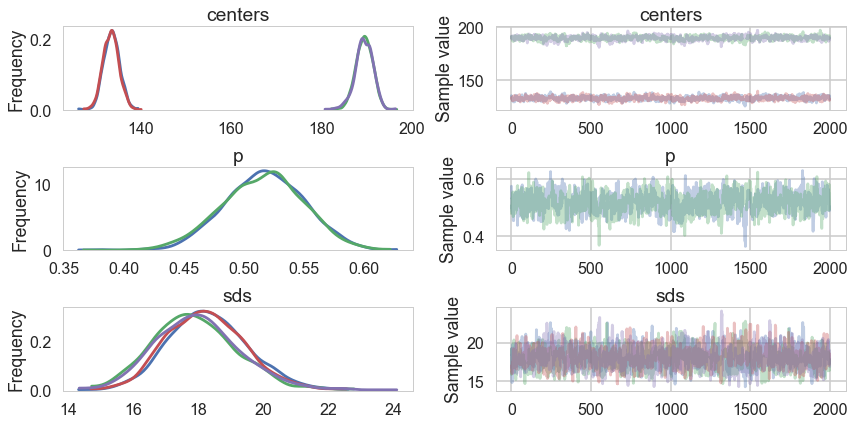

In [60]:
trace_cm2 = trace_cm2_full[5000::5]
pm.traceplot(trace_cm2, varnames=['centers', 'p', 'sds']);

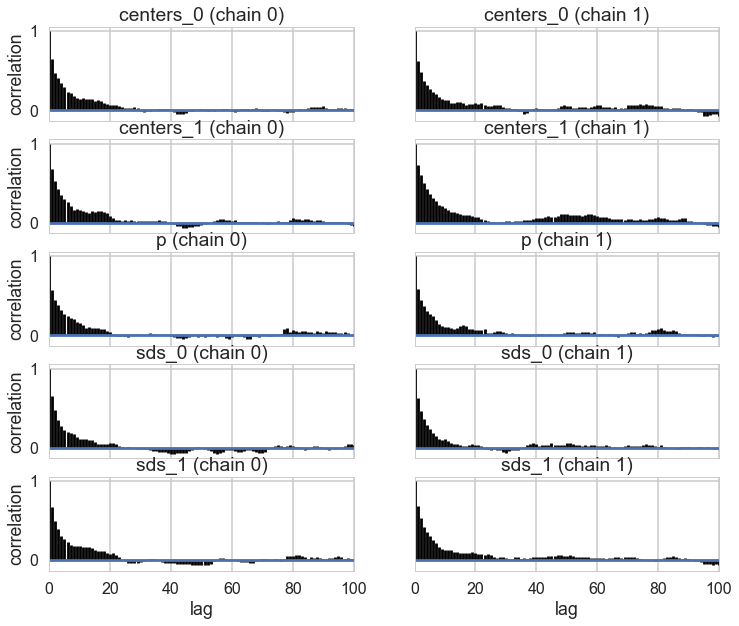

In [61]:
pm.autocorrplot(trace_cm2, varnames=['centers', 'p', 'sds']);

There is still quite a bit of autocorrelation and we might want to sample longer. But let us see how we did.

In [62]:
assign_trace = trace_cm2['assignment_te']

In [63]:
zpred2=1*(assign_trace.mean(axis=0) > 0.5)
confusion_matrix(zte, zpred2)

array([[233,  13],
       [ 17, 217]])

In [64]:
accuracy_score(zte, zpred2)

0.9375

The accuracy has improved just by having some additional terms in the likelihood!

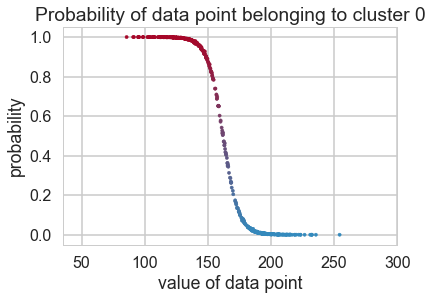

In [65]:

cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
plt.scatter(xte, 1 - assign_trace.mean(axis=0), cmap=cmap,
        c=assign_trace.mean(axis=0), s=10)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("Probability of data point belonging to cluster 0")
plt.ylabel("probability")
plt.xlabel("value of data point")